In [3]:
import pysam
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from scipy.sparse import csr_matrix
from tqdm import tqdm
#from matplotlib_scalebar.scalebar import ScaleBar
from datetime import datetime
#import umap
#umap.UMAP().fit_transform(np.random.randn(10_000, 20))

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 1000)
import subprocess

def sort_cnt(arr):
    npcnt=np.array(np.unique(arr,return_counts=True)).T
    dfcnt=pd.DataFrame(npcnt)
    dfcnt[1]=dfcnt[1].astype('int')
    dfcnt=dfcnt.sort_values(by=1,ascending=False)
    return dfcnt

def rounder(adata):
    rad=1500/.73;pad=50;
    rx=np.mean(adata.obs['x']);ry=np.mean(adata.obs['y'])
    #adata.obs['x']=adata.obs['x']-rx;adata.obs['y']=adata.obs['y']-ry
    #adata.obsm['spatial']=adata.obs[['x','y']].values
    adata=adata[(adata.obs['x']-rx)**2+(adata.obs['y']-ry)**2<=rad**2].copy()

    crop=[np.min(adata.obsm['spatial'][:,0])-pad,np.max(adata.obsm['spatial'][:,0])+pad,\
    np.max(adata.obsm['spatial'][:,1])+pad,np.min(adata.obsm['spatial'][:,1])-pad]
    return adata,crop

def marker_plot(adata,puck,markers,crop,t=0,nrow=10,ncol=5,wd=6,spot=50,alpha=.6,rembar=True,vmx='p99.2'):
    fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*wd,nrow*wd), gridspec_kw={'wspace':0.01})
    axr=ax.ravel()
    #sc.pl.spatial(adata, color='total_counts',vmax='p99.2',spot_size=40,frameon=False,
    #                  crop_coord=crop,cmap='plasma',alpha=.6,ax=axr[0], show=False)
    for i,gene in enumerate(markers):
        #i=i+1
        try:
            #ad=adata[ (adata[:,gene].X>0)]
            #if ad.shape[0]>10000:
            #    t=0;print(ad.shape[0],gene,adata[ (adata[:,gene].X>t)].shape[0])
            #else:
            #    t=0;print(ad.shape[0],gene)
            if vmx is not None:
                
                sc.pl.spatial(adata[ (adata[:,gene].X>t)], color=gene,vmax=vmx,
                          spot_size=spot,ax=axr[i], show=False,frameon=False,#frameon=True,
                              crop_coord=crop,
                              #crop_coord=[300,5000,5100,400],
                              #crop_coord=[500,4600,4800,400],
                              cmap='plasma',alpha=alpha,alpha_img=.8)
            else:
                sc.pl.spatial(adata[ (adata[:,gene].X>t)], color=gene,
                          spot_size=spot,ax=axr[i], show=False,frameon=False,#frameon=True,
                              crop_coord=crop,
                              #crop_coord=[300,5000,5100,400],
                              #crop_coord=[500,4600,4800,400],
                              cmap='plasma',alpha=alpha,alpha_img=.8)
            #scalebar = ScaleBar(0.65,"um", length_fraction=1 / 3 / 2,frameon=False,label_loc="bottom",label=None,location="lower right")
            #axr[i].add_artist(scalebar)
            axr[i].set_title(f'{gene}', fontsize=20)#, fontweight='bold')#,f'{gene}\n{puck}' fontwieght="medium")
            cbar = axr[i].collections[0].colorbar
            if rembar:
                cbar.remove()
        except:
            axr[i].remove()
            #i=i-1
    for j in np.arange(i+1,len(axr)):
        axr[j].remove()

def mtx_adata(slideseq,i,save=True):
    folds=sorted(os.listdir(slideseq))
    print(folds[i]);fold=folds[i];date = fold.split('_')[0];puck = fold.split(date+'_')[1]
    folds=os.listdir(slideseq) #list subfolders in a head folder of samples, the mtx features barcodes and xy files all should in the same subfolder
    adata = sc.read_mtx(f'{slideseq}/{fold}/{puck}.matched.digital_expression_matrix.mtx.gz')# load in counts matrix
    adata = adata.T
    adata.var = pd.read_table(f'{slideseq}/{fold}/{puck}.matched.digital_expression_features.tsv.gz', 
                              names=['ensembl','gene'], index_col=1)# load in gene names/ids table
    barcode_xy = pd.read_table(f'{slideseq}/{fold}/{puck}_barcode_xy.txt.gz',names=['x','y'], index_col=0)# load in bead barcodes>location table
    barcodes = pd.read_table(f'{slideseq}/{fold}/{puck}.matched.digital_expression_barcodes.tsv.gz', 
                             names=['barcode'], index_col=0)# load in bead barcodes list
    adata.obs=barcodes.merge(barcode_xy,left_index=True,right_index=True)
    adata.obsm['spatial']=adata.obs.values
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=True,inplace=True)
    if save:
        adata.write_h5ad(f'{slideseq}/{fold}/adata_{puck}_raw.h5ad')
    return adata

def mtx_adata_old(slideseq,i,save=True):
    folds=sorted(os.listdir(slideseq))
    print(folds[i]);fold=folds[i];date = fold.split('_')[0];puck = fold.split(date+'_')[1]
    adata = sc.read_mtx(f'{slideseq}/{fold}/{puck}.matched.digital_expression_matrix.mtx.gz')# load in counts matrix
    adata = adata.T
    adata.var = pd.read_table(f'{slideseq}/{fold}/{puck}.matched.digital_expression_features.tsv.gz', 
                              names=['ensembl','gene'], index_col=1)# load in gene names/ids table
    coords=pd.read_table(f'{slideseq}/{fold}/{puck}_barcode_matching.txt.gz',names=['bc','x','y'], usecols=[1,2,3])
    coords.drop_duplicates('bc',inplace=True);coords.set_index('bc',inplace=True)
    barcodes = pd.read_table(f'{slideseq}/{fold}/{puck}.matched.digital_expression_barcodes.tsv.gz', names=['barcode'], index_col=0)
    adata.obs = barcodes
    adata.obsm['spatial'] = coords.loc[barcodes.index].values
    adata.obs['x']=adata.obsm['spatial'][:,0]
    adata.obs['y']=adata.obsm['spatial'][:,1]
    sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)
    if save:
        adata.write_h5ad(f'{slideseq}/{fold}/adata_{puck}_raw.h5ad')
    return adata

## make slide-seq rna-seq adata and plot markers

In [8]:
slideseq='/n/data2/dfci/medonc/cwu/chloe'

In [9]:
folds=sorted(os.listdir(slideseq))

In [10]:
folds

['2023-04-19_Puck_230206_08']

In [11]:
for i in range(len(folds)):
    #print(folds[i])
    adata=mtx_adata(slideseq,i,save=True)

2023-04-19_Puck_230206_08
2023-04-19_Puck_230206_08


In [13]:
i=0
print(folds[i]);fold=folds[i];date = fold.split('_')[0];puck = fold.split(date+'_')[1]

2023-04-19_Puck_230206_08


In [14]:
adata=sc.read(f'{slideseq}/{fold}/adata_{puck}_raw.h5ad')

In [5]:
#markers=['LYZ','NCAM1','GNLY','TRGV9','CD63','APOE','IFNGR1','IFNG','HNRNPA2B1','MARCO','CD19','TRBC2','CD3D','CD3E','LYZ','IGKC','MS4A1','CXCL9','CXCL10','VEGFA']

In [19]:
markers=['CA9','VEGFA','MS4A1','TRBC2','LYZ','IGKC']

In [140]:
#markers=['CD79A','PAX5','FCGR3A', 'CCL5', 'CD44', 'C1QA', 'GBP1','GBP5', 'ITGB2']

In [ ]:
for i in [0]:
    folds=sorted(os.listdir(slideseq))
    print(folds[i]);fold=folds[i];date = fold.split('_')[0];puck = fold.split(date+'_')[1]
    adata=sc.read(f'{slideseq}/{fold}/adata_{puck}_raw.h5ad')
    #sc.pp.filter_cells(adata,min_counts=100)
    #adata,crop=rounder(adata)
    #crop=[300,2200,2200,300]
    crop=[100,5000,5000,300]
    marker_plot(adata,puck,markers,crop,t=0,nrow=2,ncol=3,wd=6,alpha=.8,spot=70,rembar=False)
    plt.savefig(f'{slideseq}/{fold}/markers_{puck}.pdf',bbox_inches='tight');

## convert matched bam to fastq (needs pigz with current options)

In [125]:
folds=sorted(os.listdir(slideseq))
i=0
print(folds[i]);fold=folds[i];date = fold.split('_')[0];puck = fold.split(date+'_')[1]
adata=sc.read(f'{slideseq}/{fold}/adata_{puck}_raw.h5ad')

2023-04-19_Puck_230206_08


In [126]:
## command line for mapping unmapped

In [127]:
bam_file=f'{slideseq}/{fold}/{puck}.matched'

In [128]:
bam_file

'/n/data2/dfci/medonc/cwu/chloe/2023-04-19_Puck_230206_08/Puck_230206_08.matched'

In [131]:
subprocess.call([ 'sbatch','/home/meb521/scripts/matchbam2fq.sh', bam_file]) ## for submitting as a job

0

In [132]:
#subprocess.call([ '/home/meb521/scripts/matchbam2fq.sh', bam_file]) # for running on the current node

In [133]:
## command line for mapping unmapped reads to emu 16s reference > change accordingly if mode changes ('sr' for short reads, 'map-ont' for nanopore) or reference changes (virus, bacteria, fungi, etc.)

In [135]:
input_fastq=f'{bam_file}_unmapped.fastq.gz'
out_name=f'{bam_file}_emu'

In [136]:
input_fastq

'/n/data2/dfci/medonc/cwu/chloe/2023-04-19_Puck_230206_08/Puck_230206_08.matched_unmapped.fastq.gz'

In [137]:
out_name

'/n/data2/dfci/medonc/cwu/chloe/2023-04-19_Puck_230206_08/Puck_230206_08.matched_emu'

In [138]:
align_comm='/home/meb521/scripts/align_one.sh'
ref_emu='/home/meb521/refs/emu_16s_species.fasta.gz'
align_comm='/home/meb521/scripts/align_one.sh'

# input directory set '' because the input and output filename are full path
#to_run=[ 'sbatch', align_comm, 'sr', ref_emu, '', input_fastq ,out_name] #run as job

to_run=[ align_comm, 'sr', ref_emu, '', input_fastq ,out_name]  #run on the node
print(to_run)

['/home/meb521/scripts/align_one.sh', 'sr', '/home/meb521/refs/emu_16s_species.fasta.gz', '', '/n/data2/dfci/medonc/cwu/chloe/2023-04-19_Puck_230206_08/Puck_230206_08.matched_unmapped.fastq.gz', '/n/data2/dfci/medonc/cwu/chloe/2023-04-19_Puck_230206_08/Puck_230206_08.matched_emu']


In [139]:
subprocess.call(to_run)

0

In [ ]:
## plot host counts

In [ ]:
ax=sc.pl.spatial(adata,color='total_counts',show=False,
                  spot_size=80,frameon=False,vmax='p99.3',
                  crop_coord=[300,5000,5000,300],alpha=.5,cmap='plasma',title='total human UMI')
plt.savefig(f'{slideseq}/{fold}/{puck}_host_umi.pdf',bbox_inches='tight');

In [140]:
# get the aligned file and the initial unampped bam which contains barcode/umi information

In [141]:
f_match=f'{slideseq}/{fold}/{puck}.matched_unmapped.bam'
f_map=f'{slideseq}/{fold}/{puck}.matched_emu.sam'

print(f_map)

/n/data2/dfci/medonc/cwu/chloe/2023-04-19_Puck_230206_08/Puck_230206_08.matched_emu.sam


In [142]:
# table of taxonomic data for the sequences inside emu_16s_species.fasta.gz

In [143]:
tax=pd.read_table(f'{slideseq}/taxonomy.tsv')

In [144]:
tax

,tax_id,species,genus,family,order,class,phylum,clade,superkingdom,subspecies,species subgroup,species group
0,2594042,Candidatus Prometheoarchaeum syntrophicum,Candidatus Prometheoarchaeum,NaN,NaN,NaN,Candidatus Lokiarchaeota,Asgard group,Archaea,NaN,NaN,NaN
1,1920749,Candidatus Mancarchaeum acidiphilum,Candidatus Mancarchaeum,NaN,NaN,NaN,Candidatus Micrarchaeota,DPANN group,Archaea,NaN,NaN,NaN
2,1291540,Candidatus Methanomethylophilus alvus,Candidatus Methanomethylophilus,Candidatus Methanomethylophilaceae,Methanomassiliicoccales,Thermoplasmata,Euryarchaeota,Diaforarchaea group,Archaea,NaN,NaN,NaN
3,1577791,Candidatus Methanoplasma termitum,Candidatus Methanoplasma,Methanomassiliicoccaceae,Methanomassiliicoccales,Thermoplasmata,Euryarchaeota,Diaforarchaea group,Archaea,NaN,NaN,NaN
4,1406512,Candidatus Methanomassiliicoccus intestinalis,Methanomassiliicoccus,Methanomassiliicoccaceae,Methanomassiliicoccales,Thermoplasmata,Euryarchaeota,Diaforarchaea group,Archaea,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
17551,126738,Thermotoga sp. RQ7,Thermotoga,Thermotogaceae,Thermotogales,Thermotogae,Thermotogae,NaN,Bacteria,NaN,NaN,NaN
17552,471825,Haloplasma contractile,Haloplasma,Haloplasmataceae,Haloplasmatales,NaN,NaN,NaN,Bacteria,NaN,NaN,NaN
17553,1167881,Bactoderma rosea,Bactoderma,NaN,NaN,NaN,NaN,NaN,Bacteria,NaN,NaN,NaN
17554,48383,Thermothrix azorensis,Thermothrix,NaN,NaN,NaN,NaN,NaN,Bacteria,NaN,NaN,NaN


## pull reads and filter

In [145]:
samfile = pysam.AlignmentFile(f_map, 'r' ,threads=4,check_sq=False)
flags=[];reads={};i=0;save=False;extract=False
if save:
    f_name=f_map.split('.sam')[0]+'_extract.fastq'
    f= open(f_name, 'w')
for read in tqdm(samfile.fetch()):
    i+=1
    AS=read.get_tag('AS');mapq=read.mapping_quality
    if AS>70: # max alignment score (based on default aligner options) for minimap2 is 2x read length, for STAR 1x read length 
        ref=read.reference_name
        if save:
            qstrt=read.query_alignment_start;qend=read.query_alignment_end
            newnamef=f'{read.qname}_{qstrt}_{qend}_{read.flag}_{ref}'
            if extract:
                sub_seq=read.seq[qstrt:qend]
                sub_qual=read.qual[qstrt:qend]
                f.write(f'@{newnamef}\n')
                f.write(f'{sub_seq}\n')
                f.write('+\n')
                f.write(f'{sub_qual}\n')
            else:
                f.write(f'@{newnamef}\n')
                f.write(f'{read.seq}\n')
                f.write('+\n')
                f.write(f'{read.qual}\n')
            
        reads[read.qname]=ref
        flags.append([ref,read.rlen,read.qlen,AS,read.reference_start,mapq,read.flag])
        
    if i>20000000: break
if save:
    f.close()
    subprocess.call([ 'pigz', '-f', f_name ])

3039it [00:00, 67784.25it/s]


In [146]:
# stats and scores
stats=[f[1:] for f in flags]
stats=pd.DataFrame(np.array(stats))

2945


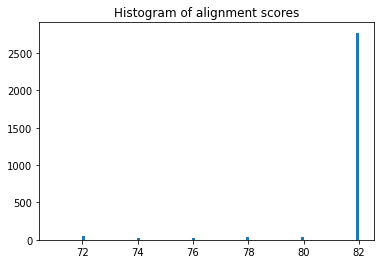

In [147]:
arr=np.array([l for l in stats[2] if l >0 and l<3000])
print(len(arr))
plt.hist(arr,bins=100);
plt.title('Histogram of alignment scores');

In [148]:
## bulk level transcript counts for species > emu
trns=[f[0] for f in flags]
cnt_trns=sort_cnt(trns)

cnt_trns.columns=['ref','count']
tax_ids=[int(f.split(':')[0]) for f in cnt_trns.ref]
cnt_trns['tax_id']=tax_ids
cnt_trns_merge=pd.merge(cnt_trns,tax,left_on='tax_id',right_on='tax_id',how='left')

In [150]:
cnt_trns_merge.species.value_counts().head(20)

Pseudomonas putida              69
Pseudomonas aeruginosa          68
Pseudomonas syringae            52
Pseudomonas chlororaphis        43
Pseudomonas fluorescens         37
Pseudomonas stutzeri            24
Pseudomonas synxantha           18
Pseudomonas veronii             18
Pseudomonas protegens           15
Bordetella pertussis            15
Pseudomonas oleovorans          13
Achromobacter xylosoxidans      13
Pseudomonas monteilii           12
Acinetobacter baumannii         12
Pseudomonas fulva               12
Pseudomonas parafulva           12
Pseudomonas orientalis          12
Achromobacter insolitus         11
Stenotrophomonas maltophilia    11
Pseudomonas azotoformans        11
Name: species, dtype: int64

## map barcodes

In [151]:
bcs=[];trans=[];bac_dic={}
samfile = pysam.AlignmentFile(f_match, 'rb', check_sq=False)
for read in tqdm(samfile.fetch(until_eof=True)):
    if reads.get(read.qname) is not None:
        #BC=read.get_tag('XC')+'-1'#.split('-')[0]
        BC=read.get_tag('XB')#.split('-')[0]
        UMI=read.get_tag('XM')
        trans.append(reads[read.qname])
        bcs.append(BC)
        try:
            bac_dic[reads[read.qname]].append([BC,UMI])
        except:
            bac_dic[reads[read.qname]]=[[BC,UMI]]
    

bcs_uni=np.unique(bcs)

print(bcs_uni.shape)

trans_uni=np.unique(trans)

len(set(adata.obs.index) & set(bcs_uni))

8910197it [00:17, 496092.84it/s]

(692,)


692

## make adata 

In [ ]:
bac_np = np.zeros( (len(bcs_uni),len(trans_uni)) )
bac_df = pd.DataFrame(bac_np, index=bcs_uni, columns=trans_uni)

for bac in trans_uni:
    uniques = np.unique(bac_dic[bac], axis=0) # all unique pairs of bc and umi
    if len(uniques)>0:
        bcs, cnts = np.unique(uniques[:,0], return_counts=True) # all barcodes
        for i in range(len(cnts)):
            if cnts[i]>0:
                bac_df.at[bcs[i],bac]+=cnts[i]

bac_df=AnnData(bac_df)

bac_df.X = csr_matrix(bac_df.X)
sc.pp.filter_genes(bac_df, min_counts=1)
sc.pp.filter_cells(bac_df, min_counts=1)
sc.pp.calculate_qc_metrics(bac_df, percent_top=None, log1p=None, inplace=True)

tax_ids=[int(f.split(':')[0]) for f in bac_df.var.index]

bac_df.var['tax_id']=tax_ids

bac_df.var=bac_df.var.reset_index()

bac_df.obs['log10_counts']=np.log10(bac_df.obs['total_counts'])

bac_df.obs=pd.merge(bac_df.obs,adata.obs[['x','y']],how='left',left_index=True,right_index=True)
bac_df.obsm['spatial']=bac_df.obs[['x','y']].values


tax_meta=pd.merge(bac_df.var,tax,left_on='tax_id',right_on='tax_id',how='left')
tax_meta=tax_meta.set_index('index')
bac_df.var=tax_meta

bac_df.var=bac_df.var.drop(columns=['clade', 'superkingdom', 'subspecies','species subgroup', 'species group'])

bac_df.var.sort_values(by='total_counts',ascending=False).to_csv(f'{slideseq}/{fold}/{puck}_emu_species.csv')

bac_df.write(f'{slideseq}/{fold}/{puck}_emu.h5ad')

ax=sc.pl.spatial(bac_df[bac_df.obs.total_counts>0],color='total_counts',show=False,
                  spot_size=80,frameon=False,vmax='p99.3',
                  crop_coord=[300,5000,5000,300],alpha=.5,cmap='plasma',title='total 16s UMI')
plt.savefig(f'{slideseq}/{fold}/{puck}_16s_emu.pdf',bbox_inches='tight');

## plotting species and genera

In [153]:
all_16s=pd.read_csv(f'{slideseq}/{fold}/{puck}_emu_species.csv')

In [154]:
bac_df=sc.read(f'{slideseq}/{fold}/{puck}_emu.h5ad')

In [155]:
# taxa level to group and plot

In [156]:
level='genus'

In [157]:
ss=pd.DataFrame(all_16s.groupby(level)['n_cells_by_counts'].sum())

In [158]:
ss=ss.sort_values(by='n_cells_by_counts',ascending=False)

In [159]:
ss[ss.n_cells_by_counts>20]

,n_cells_by_counts
genus,
Pseudomonas,2126
Achromobacter,168
Bordetella,96
Acinetobacter,32


In [160]:
ss=ss[ss.n_cells_by_counts>20].copy()

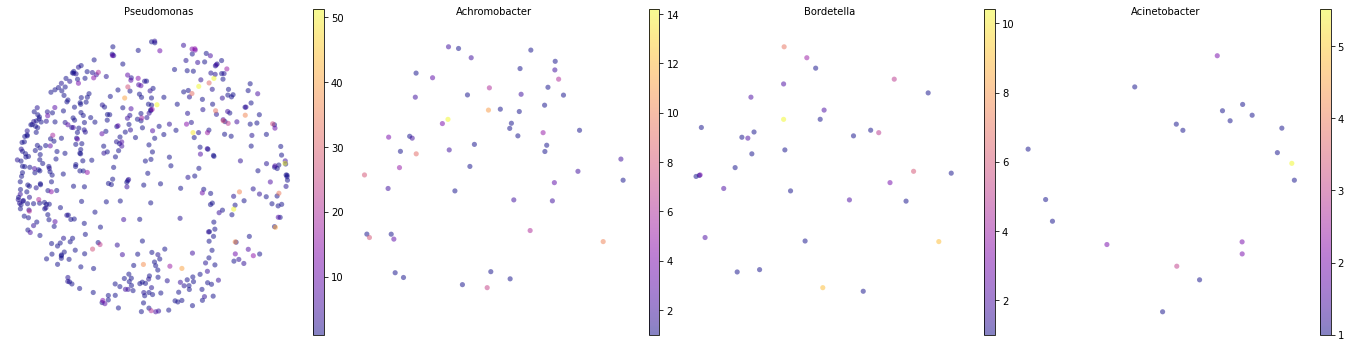

In [161]:
nrow=1;ncol=4;wd=6
fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*wd,nrow*wd), gridspec_kw={'wspace':0.01})
axr=ax.ravel()
for i,gene in enumerate(ss.index):
    
        bac_cp=bac_df[:,bac_df.var[f'{level}']==gene].copy()
        sc.pp.filter_cells(bac_cp, min_counts=1)
        sc.pp.calculate_qc_metrics(bac_cp, percent_top=None, log1p=None, inplace=True)
        #print(bac_cp.shape)
        sc.pl.spatial(bac_cp,color='total_counts',ax=axr[i], show=False,
              spot_size=80,frameon=False,vmax='p99.2',
              crop_coord=[300,5000,5000,300],alpha=.5,cmap='plasma')
        axr[i].set_title(f'{gene}', fontsize=10)#, fontweight='bold')#,f'{gene}\n{puck}' fontwieght="medium")
        cbar = axr[i].collections[0].colorbar
        #cbar.remove()
        